In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.maths import robust

from pynrc.reduce.calib import bp_fix
from pynrc.nrc_utils import fourier_imshift, fshift
from pynrc.nrc_utils import pad_or_cut_to_size, frebin

from astropy.io import fits
from poppy.fwcentroid import fwcentroid

pynrc.setup_logging('WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## Load NIRCam PSF class

In [3]:
# Some FITs files
f1 = '/Users/jarron/Downloads/Simulated_20220713/pynrc_jw01386018001_03104_00001_nrca5_calints.fits'
f2 = '/Users/jarron/Downloads/Simulated_20220713/pynrc_jw01386018001_03105_00001_nrca5_calints.fits'
f3 = '/Users/jarron/Downloads/Simulated_20220713/pynrc_jw01386018001_03106_00001_nrca5_calints.fits'

In [4]:
# Parse observation settings
hdul = fits.open(f1)
hdr0 = hdul[0].header
hdul.close()

date = hdr0['DATE']

filt = hdr0['FILTER']
image_mask = hdr0.get('CORONMSK', None)
if image_mask is None:
    pass
elif '335R' in image_mask:
    image_mask = 'MASK335R'
elif '430R' in image_mask:
    image_mask = 'MASK430R'
elif '210R' in image_mask:
    image_mask = 'MASK210R'
elif 'LW' in image_mask:
    image_mask = 'MASKLWB'
elif 'SW' in image_mask:
    image_mask = 'MASKSWB'
    
pupil_mask = hdr0.get('PUPIL', None)
if pupil_mask is None:
    pass
elif 'RND' in pupil_mask:
    pupil_mask = 'CIRCLYOT'
elif 'BAR' in pupil_mask:
    pupil_mask = 'WEDGELYOT'
    
# Create NIRCam object
# Exclude coeff loads since generating PSF on-the-fly
nrc = pynrc.nrc_hci(filter=filt, image_mask=image_mask, pupil_mask='CIRCLYOT',
                    large_grid=True, fov_pix=321, autogen_coeffs=False)

iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-07-14T05:52:33.127
                        MJD: 59774.2448278588

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022071302-NRCA3_FP1-1.fits
	Date (MJD):	 59772.6632
	Delta time:	 -1.5816 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022071502-NRCA3_FP1-1.fits
	Date (MJD):	 59775.4192
	Delta time:	 1.1744 days
User requested choosing OPD before date 2022-07-14T05:52:33.127, which is R2022071302-NRCA3_FP1-1.fits, delta time -1.582 days
INFO: MAST API token accepted, welcome Jarron Leisenring [astroquery.mast.auth]
[astroquery:INFO] MAST API token accepted, welcome Jarron Leisenring
Importing and format-converting OPD from /Users/jarron/NIRCam/webbpsf-data/MAST_JWST_WSS_OPDs/R2022071302-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


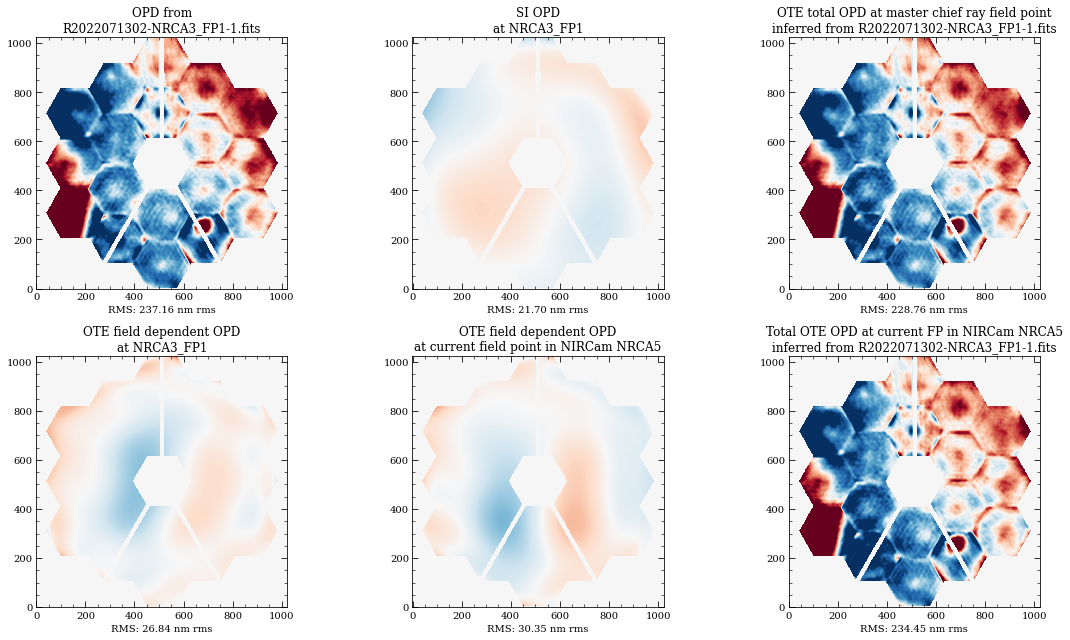

In [5]:
# Load date-specific OPD file
nrc.load_wss_opd_by_date(date=date, choice='before', verbose=True, plot=True)

## Estimate locations of binary stars

In [6]:
hdul = fits.open(f2)

hdr0 = hdul[0].header
hdr1 = hdul[1].header

imarr = hdul[1].data.astype('float')

# Create array of bad pixels
bparr = np.zeros_like(imarr).astype('bool')
for i, im in enumerate(imarr):
    bparr[i] = (hdul['DQ'].data[i]==1) | (im==0) | np.isnan(im)
    
# Subtract median of local backgrounds
xgrid, ygrid = np.mgrid[0:imarr.shape[-1],0:imarr.shape[-2]]
for i, im in enumerate(imarr):
    # Exclude bad pixels and choose upper section of images as bg region
    ind_good = (~bparr[i]) & (xgrid>250)
    im_good = im[ind_good]

    # Get median and sigma
    med = np.median(im_good)
    std = robust.medabsdev(im_good)
    
    # Select pixels within background distribution
    # This is actually non-Gaussian, so really want peak of distribution
    # rather than median, but this works for now.
    ind_bg = (im_good > (med - 10*std)) & (im_good < (med + 10*std))
    bg_med = np.median(im_good[ind_bg])
    
    # Subtraction median from 
    imarr[i,~bparr[i]] -= bg_med

# Set bad pixels to NaNs for easy ignoring
for i in range(len(imarr)):
    imarr[i,bparr[i]] = np.nan

# Median combine all frames
im_med = np.nanmedian(imarr, axis=0)

In [7]:
# Dictionary of useful info
dict_info = {
    'hdr0': hdr0, 'hdr1': hdr1, 'data': imarr, 'bparr': bparr, 'im_med': im_med,
}

217 43
211 63


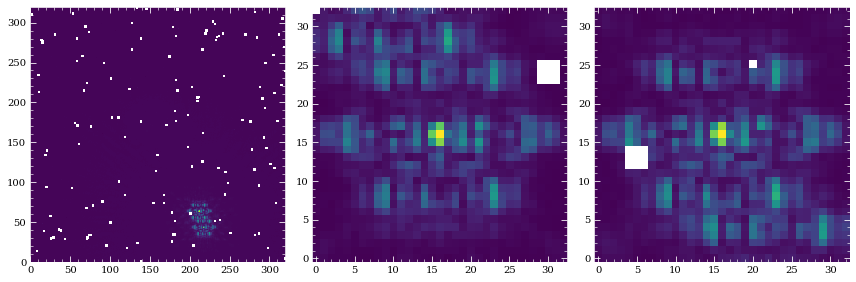

In [8]:
# Find stellar locations
# Assume top two pixel values

# Guess initial locations
vals_sort = np.sort(im_med[~np.isnan(im_med)])
vals_max = vals_sort[::-1][0:2]

# Store subarray info
xysub = 33
dict_sub = {}
for i, vmax in enumerate(vals_max):
    yi, xi = np.argwhere(im_med==vmax)[0]
    print(xi,yi)
    x1, y1  = (int(xi-xysub/2 + 0.5), int(yi - xysub/2 + 0.5))
    x2, y2 = np.array([x1,y1]) + xysub
    dict_sub[i+1] = {
        'xy_i': (xi,yi), # Pixel index of off-axis M-Star
        'xind': (x1,x2), # Sub-image crop index (x-axis)
        'yind': (y1,y2), # Sub-image crop index (y-axis)
        'imcut': im_med[y1:y2,x1:x2],
        'vmax' : vals_max[i],
    }
dict_info['dict_sub'] = dict_sub
    
fig, axes = plt.subplots(1,3, figsize=(12,5))

axes[0].imshow(im_med)
axes[1].imshow(dict_sub[1]['imcut'])
axes[2].imshow(dict_sub[2]['imcut'])

for ax in axes:
    # Tick Marks
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

fig.tight_layout()

## Cross-correlation analysis

In [9]:
def correl_images(im1, im2, mask=None):
    """ Image correlation coefficient
    
    Calculate the 2D cross-correlation coefficient between two
    images or array of images. Images must have the same x and
    y dimensions and should alredy be aligned.
    
    Parameters
    ----------
    im1 : ndarray
        Single image or image cube (nz1, ny1, nx1).
    im2 : ndarray
        Single image or image cube (nz2, ny1, nx1). 
        If both im1 and im2 are cubes, then returns
        a matrix of  coefficients.
    mask : ndarry or None
        If set, then a binary mask of 1=True and 0=False.
        Excludes pixels marked with 0s/False. Must be same
        size/shape as images (ny1, nx1).
    """
    
    sh1 = im1.shape
    sh2 = im2.shape

    if len(sh1)==2:
        ny1, nx1 = sh1
        nz1 = 1
        im1.reshape([nz1,ny1,nx1])
    else:
        nz1, ny1, nx1 = sh1

    if len(sh2)==2:
        ny2, nx2 = sh2
        nz2 = 1
        im2.reshape([nz2,ny2,nx2])
    else:
        nz2, ny2, nx2 = sh2

    assert (nx1==nx2) and (ny1==ny2), "Input images must have same sizes"

    im1 = im1.reshape([nz1,-1])
    im2 = im2.reshape([nz2,-1])

    # Apply masking
    if mask is not None:
        im1 = im1[:, mask.ravel()]
        im2 = im2[:, mask.ravel()]

    # Subtract mean from each axes
    im1 = im1 - np.mean(im1, axis=1).reshape([-1,1])
    im2 = im2 - np.mean(im2, axis=1).reshape([-1,1])

    # Calculate numerators for each image pair
    correl_top = np.dot(im1, im2.T)

    # Calculate denominators for each image pair
    im1_tot = np.sum(im1**2, axis=1)
    im2_tot = np.sum(im2**2, axis=1)
    correl_bot = np.sqrt(np.multiply.outer(im1_tot, im2_tot))

    correl_fin = correl_top / correl_bot
    if correl_fin.size==1:
        return correl_fin.flatten()[0]
    else:
        return correl_fin.squeeze()

In [10]:
def gen_psf_offsets(psf, xysub, xlim_pix=(-3,3), ylim_pix=(-3,3), dxy=0.05,
    psf_osamp=2, return_oversample=False, shift_func=fourier_imshift):
    """Generate series PSFs offset in a fine pixel grid
    
    Parameters
    ==========
    psf : ndarray
        Input PSF
    xysub : int
        Final output size to crop shifted PSFs.
        Specified as detector pixels.
    xlim_pix : array-like
        Pixel shifting limits along x-axis. 
        Specified as detector pixels.
    ylim_pix : array-like
        Pixel shifting limits along y-axis. 
        Specified as detector pixels.
    dxy : float
        Size of sub-pixel shifts along x and y axes 
        between pixel limits. Specified as detector pixels.
    psf_osamp : int
        Oversampling of input PSF.
    return_oversample : bool
        Return PSFs as oversampled or 
    shift_func : func
        Shifting routine to use.
    """

    # Range of offsets to probe in fractional pixel steps
    xmin_pix, xmax_pix = xlim_pix
    ymin_pix, ymax_pix = ylim_pix

    # Pixel offsets
    xoff_pix = np.arange(xmin_pix, xmax_pix+dxy, dxy)
    yoff_pix = np.arange(ymin_pix, ymax_pix+dxy, dxy)

    # Create position grid and flatten
    # Defined in detector pixels
    xoff_all, yoff_all = np.meshgrid(xoff_pix, yoff_pix)
    xoff_all = xoff_all.flatten()
    yoff_all = yoff_all.flatten()
    
    # Make initial crop so we not shifting entire image
    crop_init = xysub + int(2*(np.max(np.abs(np.concatenate([xoff_pix, yoff_pix]))) + 1))
    crop_init *= psf_osamp  # account for oversampling of input psf
    psf0 = pad_or_cut_to_size(psf, crop_init)

    # Create a series of shifted PSFs to compare to images
    npsf = len(xoff_all)
    psf_sh_all = []
    xysub_osamp = xysub * psf_osamp
    for xoff, yoff in tqdm(zip(xoff_all*psf_osamp, yoff_all*psf_osamp), total=npsf):
        psf_sh = pad_or_cut_to_size(psf0, xysub_osamp, offset_vals=(yoff,xoff), shift_func=shift_func)
        psf_sh_all.append(psf_sh)
    psf_sh_all = np.asarray(psf_sh_all)
    
    if not return_oversample:
        psf_sh_all = frebin(psf_sh_all, scale=1/psf_osamp)

    return xoff_pix, yoff_pix, psf_sh_all

In [11]:
def sample_crosscorr(corr, xcoarse, ycoarse, xfine, yfine):
    """Perform a cubic interpolation over the coarse grid"""
    
    from scipy.interpolate import griddata
    
    xycoarse = np.asarray(np.meshgrid(xcoarse, ycoarse)).reshape([2,-1]).transpose()

    # Sub-sampling shifts to interpolate over
    xv, yv = np.meshgrid(xfine, yfine)
    
    # Perform cubic interpolation
    corr_fine = griddata(xycoarse, corr.flatten(), (xv, yv), method='cubic')
    
    return corr_fine

def find_max_crosscorr(corr, xsh_arr, ysh_arr, sub_sample):
    """Interpolate finer grid onto cross corr map and location max position"""
    
    # Sub-sampling shifts to interpolate over
    # sub_sample = 0.01
    xsh_fine_vals = np.arange(xsh_arr[0],xsh_arr[-1],sub_sample)
    ysh_fine_vals = np.arange(ysh_arr[0],ysh_arr[-1],sub_sample)
    corr_all_fine = sample_crosscorr(corr,  xsh_arr, ysh_arr, xsh_fine_vals, ysh_fine_vals)

    # Fine position
    iymax, ixmax = np.argwhere(corr_all_fine==np.max(corr_all_fine))[0]
    xsh_fine, ysh_fine = xsh_fine_vals[ixmax], ysh_fine_vals[iymax]
    
    return xsh_fine, ysh_fine

### Generate simulated PSF

In [39]:
# Create simulated PSF
sp = pynrc.stellar_spectrum('M0V')

# coords = (x1_init, y1_init)
x, y = dict_info['dict_sub'][1]['xy_i']
coords_idl = nrc.siaf_ap.sci_to_idl(x, y)

psf_template = nrc.calc_psf(sp=sp, return_hdul=False, coord_vals=coords_idl, coord_frame='idl')
psf_template = psf_template / np.sum(psf_template)

In [40]:
# Find center of off-axis PSF and shift PSF to center of image
# Not strictly necessary, but makes cross-correlation results easier to interpret
for ii in np.arange(5):
    
    psf_off = pad_or_cut_to_size(psf_template, 64)

    # Depend on COM algorithm to find offset; do this on detector pizel binning
    cent_of_mass = fwcentroid(psf_off, halfwidth=4, maxiterations=100)
    imcen = np.array([(psf_off.shape[0] - 1) / 2., (psf_off.shape[1] - 1) / 2.])
    ycen_psf, xcen_psf = np.array(cent_of_mass) - imcen

    psf_template = fourier_imshift(psf_template, -xcen_psf, -ycen_psf)

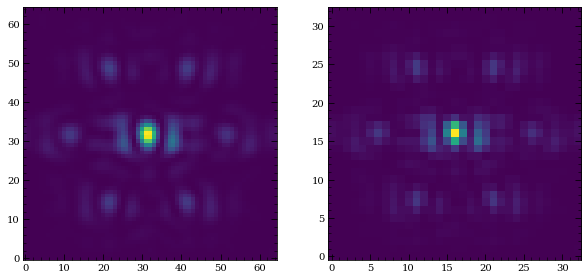

In [42]:
osamp = nrc.oversample
psf_off_rebin = frebin(psf_template, scale=1/osamp)

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(pad_or_cut_to_size(psf_template, 65))
axes[1].imshow(pad_or_cut_to_size(psf_off_rebin, 33))

### PSF correlation

In [43]:
xysub = 33
dxy = 0.05
res = gen_psf_offsets(psf_template, xysub, xlim_pix=(-2,2), ylim_pix=(-2,2), dxy=dxy,
                      psf_osamp=osamp, return_oversample=False, shift_func=fourier_imshift)
    
xoff_pix, yoff_pix, psf_sh_all = res

  0%|          | 0/6561 [00:00<?, ?it/s]

PSF offset: (-0.23, -0.08) pixels
PSF offset: (-0.19, -0.01) pixels


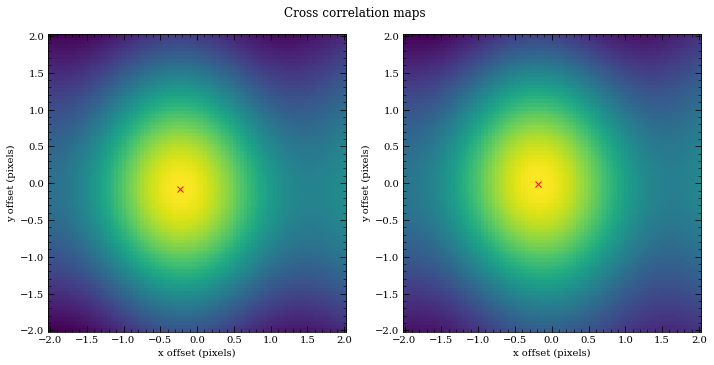

In [44]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
extent = [xoff_pix.min()-dxy/2, xoff_pix.max()+dxy/2, 
          yoff_pix.min()-dxy/2, yoff_pix.max()+dxy/2]

dict_sub = dict_info['dict_sub']
for i, k in enumerate(dict_sub.keys()):

    imsub = dict_sub[k]['imcut']
    mask = ~np.isnan(imsub)
    cc = correl_images(imsub, psf_sh_all, mask=mask)
    
    # Cubic interpolation over a finer sampling grid of 0.01 pixels
    xbest, ybest = find_max_crosscorr(cc, xoff_pix, yoff_pix, 0.01)
    print(f'PSF offset: ({xbest:.2f}, {ybest:.2f}) pixels')
    
    dict_sub[k]['psf_xyoff'] = np.array([xbest,ybest])
    
    ax = axes[i]
    cc = cc.reshape([len(yoff_pix), len(xoff_pix)])
    ax.imshow(cc, extent=extent)
    ax.plot(xbest, ybest, marker='x', color='r')
    
    ax.set_xlabel('x offset (pixels)')
    ax.set_ylabel('y offset (pixels)')
    
fig.suptitle('Cross correlation maps')
fig.tight_layout()

## Compare simulated PSF with data

In [45]:
def binary_model(psf, xy_arr, scl_arr, shape_out=(320,320), oversample=2, 
                 shift_func=fshift, **kwargs):
    """ Create binary model image 
    
    Input an oversampled PSF template, shift to specified locations, scale by some flux
    """
    
    psf = psf / psf.sum()
    
    if isinstance(shape_out, (int)):
        shape_out = (shape_out,shape_out)
    shape_out = np.array(shape_out)
    imcen = (shape_out - 1) / 2.
    
    # Oversampled version
    shape_out_over = np.array(shape_out) * oversample
    
    nobj = len(scl_arr)
    imout = np.zeros(shape_out)
    for i in range(nobj):
        offset_vals = np.array(xy_arr[i])[::-1] - imcen
        im_over = pad_or_cut_to_size(psf, shape_out_over, offset_vals=oversample*offset_vals, 
                                     shift_func=shift_func)
        im_rebin = frebin(im_over, scale=1/oversample)
        im_rebin /= im_rebin.max()
        imout += scl_arr[i] * pad_or_cut_to_size(im_rebin, shape_out)
        
    return imout


def binary_model_lsq_func(params, psf, **kwargs):
    
    # Convert to input for binary_model function
    params = np.array(params)
    xv1, yv1, xv2, yv2 = params[0:4]
    xy_arr = [(xv1, yv1), (xv2, yv2)]
    
    vals_max = params[4:6]
    
    model = binary_model(psf, xy_arr, vals_max, **kwargs)  
    
    return model

In [46]:
dict_sub = dict_info['dict_sub']
xy_arr = []
scl_arr = []
for i, k in enumerate(dict_sub.keys()):
    x, y = dict_sub[k]['xy_i'] + dict_sub[k]['psf_xyoff']
    xy_arr.append((x,y))
    scl_arr.append(dict_sub[k]['vmax'])

In [60]:
from scipy import optimize

def errfunc(params, psf, data, ind_bad=None, bg_sub=False, **kwargs):
    
    model = binary_model_lsq_func(params, psf, **kwargs)
    
    params = np.array(params)
    xv1, yv1, xv2, yv2 = params[0:4]
    x0, y0 = np.mean([xv1,xv2]).astype('int'), np.mean([yv1,yv2]).astype('int')
    x1, x2 = (x0-50, x0+50)
    y1, y2 = (y0-50, y0+50)
    
    data_crop = data[y1:y2,x1:x2]
    mod_crop = model[y1:y2,x1:x2]
    
    # Remove local background?
    if bg_sub:
        data_crop = data_crop - np.nanmedian(data_crop)
        mod_crop = mod_crop - np.nanmedian(mod_crop)
        
    diff = data_crop - mod_crop
    
    # Exclude bad pixels
    if ind_bad is not None:
        ind_bad = ind_bad[y1:y2,x1:x2]
        diff = diff[~ind_bad]
    
    return diff.flatten()

# 
pinit = np.concatenate([np.asarray(xy_arr).flatten(), scl_arr])
bounds = [[p-1,p+1] for p in pinit[:-2]]
bounds = bounds + [[pinit[4]/2,2*pinit[4]], [pinit[5]/2,2*pinit[5]]]
bounds = np.array(bounds).T

im_input = imarr[0]

args = (psf_template, im_input)

# Mask NaNs
ind_bad = np.isnan(im_input)
# Mask inner regions of PSFs
xv1, yv1, xv2, yv2 = pinit[0:4]
rvals1 = nrc_utils.dist_image(im_input, center=(xv1,yv1))
rvals2 = nrc_utils.dist_image(im_input, center=(xv2,yv2))
ind_bad = ind_bad | (rvals1<10) | (rvals2<10)
kwargs = {'ind_bad': ind_bad, 'bg_sub': False}

# res = optimize.leastsq(errfunc, pinit, args=args)
res = optimize.least_squares(errfunc, pinit, args=args, kwargs=kwargs, bounds=bounds)

In [61]:
pinit

array([  216.77      ,    42.92      ,   210.81      ,    62.99      ,
       15917.74927622, 15007.14413467])

In [62]:
res.x

array([  216.1893356 ,    42.61409944,   210.2342446 ,    62.79275019,
       31835.4985519 , 30014.28826933])

In [63]:
model = binary_model_lsq_func(res.x, psf_template)

In [65]:
diff = im_input - model


x0, y0 = np.asarray(xy_arr).mean(axis=0).astype('int')
x1, x2 = (x0-50, x0+50)
y1, y2 = (y0-50, y0+50)

im_input_sub = im_input[y1:y2,x1:x2]
model_sub = model[y1:y2,x1:x2]

if kwargs['bg_sub']:
    im_input_sub = im_input_sub - np.nanmedian(im_input_sub)
    model_sub = model_sub - np.nanmedian(model_sub)

diff_sub = im_input_sub - model_sub

-19732.22590309283
7450.681677877442


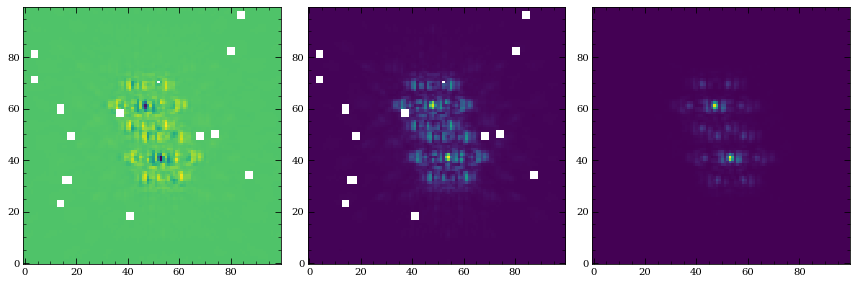

In [66]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

axes[0].imshow(diff_sub)
axes[1].imshow(im_input_sub)
axes[2].imshow(model_sub)

print(np.nanmin(diff_sub))
print(np.nanmax(diff_sub))

fig.tight_layout()

In [67]:
np.nanmedian(diff_sub), np.nanmedian(im_input_sub), np.nanmedian(model_sub)

(20.139143239088916, 45.35788691043854, 18.94554987976344)